In [1]:
from dadapy import data
import torchvision
import torch
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from collections import namedtuple
import numpy as np
from urllib.request import urlretrieve
from os.path import exists, isdir
from os import makedirs
from math import ceil

In [2]:
torch.manual_seed(0)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
def fetch_kmnist(data_path = "kmnist", force_download = True, normalize = True):
    """Function that fetches the train and test kmnist dataset and returns it in a numpy array.
    It downloads it if the file is not present or if force_download is True."""
    
    url = 'http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-'
    train_set_url = url + 'train-imgs.npz'
    test_set_url  = url + 'test-imgs.npz'
    train_labels_url = url + 'train-labels.npz'
    test_labels_url  = url + 'test-labels.npz'
    
    train_set_path = data_path + "/train_set"
    test_set_path  = data_path + "/test_set"
    train_labels_path = data_path + "/train_labels"
    test_labels_path = data_path + "/test_labels"
    
    if not isdir(data_path):
        makedirs(data_path)
    
    for path,url in [(train_set_path,train_set_url),(test_set_path,test_set_url),(train_labels_path,train_labels_url),(test_labels_path,test_labels_url)]:
        if not exists(path) or force_download:
            print(f"downloading data from {url} to {path}")
            urlretrieve(url, path)
       
    train_set = np.load(train_set_path)['arr_0'] / 255 if normalize else np.load(train_set_path)['arr_0']
    test_set  = np.load(test_set_path)['arr_0'] / 255 if normalize else np.load(test_set_path)['arr_0']
    train_labels = np.load(train_labels_path)['arr_0']
    test_labels  = np.load(test_labels_path)['arr_0']
    
    return train_set, test_set, train_labels, test_labels

In [5]:
train_set, test_set, train_labels, test_labels = fetch_kmnist(force_download = False)

In [6]:
def create_data_loaders(batch_size = 256):
    torch_train = torch.Tensor(train_set).view(-1, 1,28,28).float()
    torch_test  = torch.Tensor(test_set).view(-1,1,28,28).float()

    torch_train_set = TensorDataset(torch_train,torch.from_numpy(train_labels))
    train_dataloader = DataLoader(torch_train_set, batch_size=batch_size, shuffle=False)

    torch_test_set = TensorDataset(torch_test,torch.from_numpy(test_labels))
    test_dataloader = DataLoader(torch_test_set, batch_size=batch_size, shuffle=False)
    
    return train_dataloader,test_dataloader

train_dataloader,test_dataloader = create_data_loaders()

In [7]:
def compute_id_with_twoNN(dataset):
    _data = data.Data(dataset.reshape(-1,28*28))
    # estimate ID
    id_twoNN, _, r = _data.compute_id_2NN()
    return ceil(id_twoNN)

#id_twoNN = compute_id_with_twoNN(train_set)
id_twoNN = 21

In [8]:
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, stride = 1, padding = 0),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size = 2),
            torch.nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 2, padding = 1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size = 2, stride = 1),
            torch.nn.Flatten(),
            torch.nn.Linear(6*6*64, id_twoNN)
        )
    
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(id_twoNN, 64*8*8),
            torch.nn.ReLU(),
            torch.nn.Unflatten(1, torch.Size([64, 8, 8])),
            torch.nn.ConvTranspose2d(in_channels = 64, out_channels = 32, kernel_size = 2, stride = 2, padding = 1),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(in_channels = 32, out_channels = 1, kernel_size = 2, stride = 2, padding = 0),
            torch.nn.ReLU()
        )
    
    def forward(self, x):
        out = self.encoder(x)
        out = self.decoder(out)
        return out

In [9]:
model = AE().to(device)

In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
loss = torch.nn.MSELoss(reduction = 'sum')

In [11]:
epochs = 20
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for x,_ in iter(train_dataloader):
        x=x.to(device)
        x_hat = model(x)
        l = loss(x_hat,x)
        train_loss += l.item()
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    print("Epoch "+ str(epoch+1) + " Training loss:" + str(train_loss / (len(train_dataloader.dataset))))
    
with torch.no_grad():
    model.eval()
    test_loss=0 
    for x,_ in iter(test_dataloader):
            x=x.to(device)
            x_hat=model(x)
            l=loss(x_hat,x)
            test_loss+=l.item()
    test_loss /= len(test_dataloader.dataset)
    print("Test set loss:"+str(test_loss))

Epoch 1 Training loss:52.06885473632813
Epoch 2 Training loss:34.67284738769531
Epoch 3 Training loss:31.742447111002605
Epoch 4 Training loss:30.1793198038737
Epoch 5 Training loss:29.115782759602865
Epoch 6 Training loss:28.32284591878255
Epoch 7 Training loss:27.64875439046224
Epoch 8 Training loss:27.108711832682292
Epoch 9 Training loss:26.645543225097658
Epoch 10 Training loss:26.262873201497396
Epoch 11 Training loss:25.931363248697917
Epoch 12 Training loss:25.63745965169271
Epoch 13 Training loss:25.37910253092448
Epoch 14 Training loss:25.13785509440104
Epoch 15 Training loss:24.929784358723957
Epoch 16 Training loss:24.744746472167968
Epoch 17 Training loss:24.619119848632813
Epoch 18 Training loss:24.435818029785157
Epoch 19 Training loss:24.26121910807292
Epoch 20 Training loss:24.10282834472656
Test set loss:28.907459991455077


In [12]:
x = next(iter(train_dataloader))[0].to(device)
out = model(x)

In [13]:
def display_images(input, output):
    if input is not None:
        input_pics = input.data.cpu().numpy().transpose((0,2,3,1))
        plt.figure(figsize=(18, 4))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(input_pics[i],cmap='gray')
    plt.figure(figsize=(18, 4))
    output_pics = output.data.cpu().numpy().transpose((0,2,3,1))
    for i in range(4):
        plt.subplot(1,4,i+1)
        plt.imshow(output_pics[i],cmap='gray')

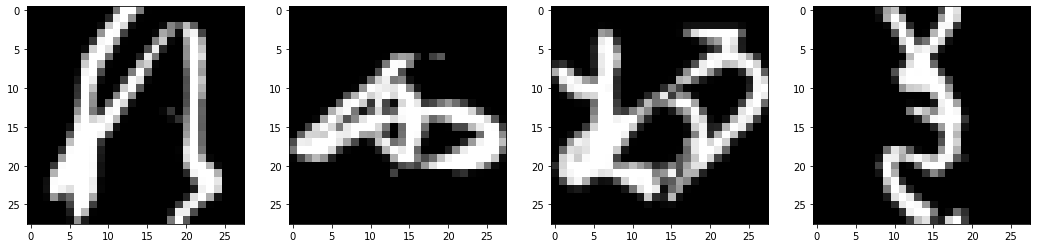

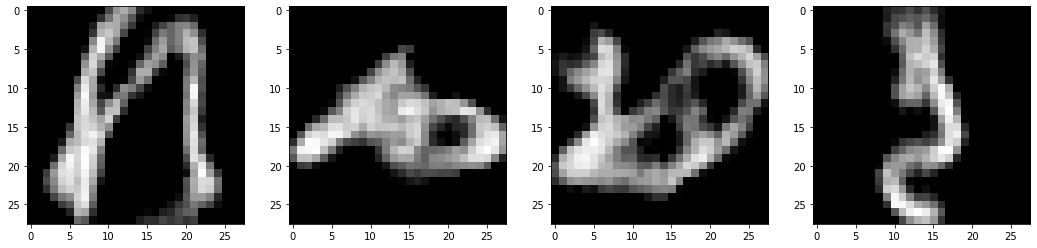

In [14]:
display_images(x,out)

In [15]:
class Classifier(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        self.layer1 = model.encoder
        self.layer2 = torch.nn.Linear(in_features = id_twoNN, out_features = 10, bias = True)
        self.activation = torch.nn.ReLU()
        
    def forward(self, x):
        x = self.activation(self.layer1(x))
        x = self.layer2(x)
        return x

In [16]:
classifier = Classifier().to(device)

In [17]:
for name,param in classifier.named_parameters():
    param.requires_grad = False if "layer1" in name else True

In [18]:
optimizer=torch.optim.Adam(filter(lambda p: p.requires_grad, classifier.parameters()), lr=1e-3)
loss=torch.nn.CrossEntropyLoss()

In [19]:
def get_accuracy(model, dataloader):
    model.eval()
    with torch.no_grad():
        correct=0
        for x, y in iter(dataloader):
            x=x.to(device)
            y=y.to(device)
            out=model(x)
            correct+=(torch.argmax(out, axis=1)==y).sum()
        return round(float(correct/len(dataloader.dataset)),4)

Test accuracy:  0.0666
Epoch:  0
Test accuracy:  0.4119
Epoch:  1
Test accuracy:  0.5004
Epoch:  2
Test accuracy:  0.5221
Epoch:  3
Test accuracy:  0.5373
Epoch:  4
Test accuracy:  0.5467
Epoch:  5
Test accuracy:  0.5569
Epoch:  6
Test accuracy:  0.5665
Epoch:  7
Test accuracy:  0.5713
Epoch:  8
Test accuracy:  0.5771
Epoch:  9
Final accuracy:  0.5818


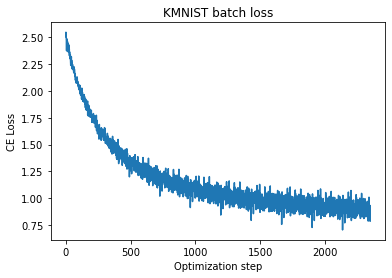

In [20]:
epochs=10
losses=[]
for epoch in range(epochs):
    print("Test accuracy: ", get_accuracy(classifier, test_dataloader))
    classifier.train()
    print("Epoch: ", epoch)
    for x, y in iter(train_dataloader):
        x=x.to(device)
        y=y.to(device)
        out=classifier(x)
        l=loss(out, y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        losses.append(l.item())
print("Final accuracy: ", get_accuracy(classifier, test_dataloader))

plt.figure()
plt.title("KMNIST batch loss")
plt.plot(losses)
plt.xlabel("Optimization step")
_ = plt.ylabel("CE Loss")